# Model validation with observation data: Gauge and altimetry

In [12]:
# Load in model discharge vals, 

# Load in river gauge data

# load altimetry, surface water extent, grace? 

import matplotlib.pyplot as plt
import geopandas as gpd
import mikeio

def plot_settings(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    # remove plot border
    for spine in ax.spines.values():
        spine.set_visible(False)

<mikeio.DataArray>
name: Q250018
dims: (time:11322)
time: 1989-01-01 00:00:00 - 2019-12-31 00:00:00 (11322 records)
geometry: GeometryUndefined()
values: [1.786, 1.772, ..., nan]

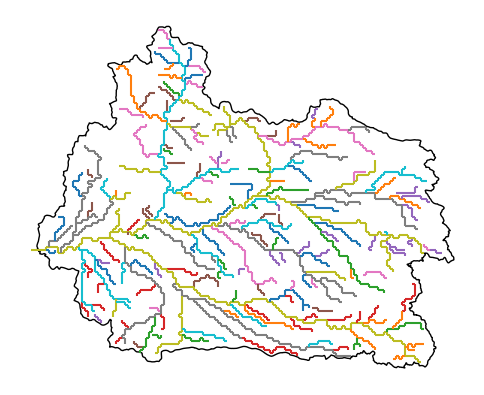

In [ ]:
# ---------------------- Domain and River Connectivity ----------------------

fig, ax = plt.subplots(figsize=(6, 6))

# Domain data
domain_shp = gpd.read_file( r"..\MapsDK\DKDomains2013\ID15_oplande_Skjern.shp")
domain_shp.plot(facecolor='none', edgecolor='black',ax=ax)

# River connectivity shapefile (simulation output)
riv_shp = gpd.read_file(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHI_RiverLinks.shp")
riv_shp.plot(column='Branch',ax=ax)
plot_settings(ax)

# Load point locations where we have Q observations
Q_obs = mikeio.read(r"..\MapsDK\Qdata\Q_filtered.dfs0")
Q_obs

In [18]:
# Read detailed TS files

detailed_ts = mikeio.read(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHIDetailedTS_M11.dfs0")
print(detailed_ts)

detailed_ts_SZ = mikeio.read(r"..\Skjern_Models\Setup\HIP_500m_Skjern_DHI.she - Result Files\HIP_500m_Skjern_DHIDetailedTS_SZ.dfs0")
print(detailed_ts_SZ.items)

<mikeio.Dataset>
dims: (time:10948)
time: 1990-01-02 18:00:00 - 2019-12-23 06:00:00 (10948 non-equidistant records)
geometry: GeometryUndefined()
items:
  0:  Q250018 <Discharge> (meter pow 3 per sec) - 3
  1:  Q250019 <Discharge> (meter pow 3 per sec) - 3
  2:  Q250020 <Discharge> (meter pow 3 per sec) - 3
  3:  Q250021 <Discharge> (meter pow 3 per sec) - 3
  4:  Q250078 <Discharge> (meter pow 3 per sec) - 3
  5:  Q250082 <Discharge> (meter pow 3 per sec) - 3
  6:  Q250090 <Discharge> (meter pow 3 per sec) - 3
  7:  Q250092 <Discharge> (meter pow 3 per sec) - 3
  8:  Q250097 <Discharge> (meter pow 3 per sec) - 3
[102.725_1 <Elevation> (meter), 102.725_2 <Elevation> (meter), 102.873_1 <Elevation> (meter), 103.1542_1 <Elevation> (meter), 103.1653_1 <Elevation> (meter), 103.1653_2 <Elevation> (meter), 104.2190_1 <Elevation> (meter), 105.374_1 <Elevation> (meter), 113.111_1 <Elevation> (meter), 114.1618_6 <Elevation> (meter), 114.1631_1 <Elevation> (meter), 83.1175_1 <Elevation> (meter), 

In [ ]:
# Read in river gauge observations

Q_obs = mikeio.read(r"..\MapsDK\Qdata\Q_filtered.dfs0")
Q_obs

,Link_ID,Topo1,Bank1,Topo2,Bank2,Bed,Width,Chainage,Branch,geometry
0,1,-0.000001,0.016,-0.000001,0.016,-1.938,73.665,84214.020,SKJERN_HATH_DK5,"LINESTRING Z (460000 6196500 -1.938, 460500 61..."
1,2,0.365529,0.000,-0.000001,0.000,-2.401,138.661,83708.180,SKJERN_HATH_DK5,"LINESTRING Z (460500 6196500 -2.401, 461000 61..."
2,3,0.368723,0.066,0.542651,-0.106,-2.788,105.723,83203.250,SKJERN_HATH_DK5,"LINESTRING Z (461000 6196500 -2.788, 461500 61..."
3,4,0.349941,-0.052,0.510638,-0.191,-2.402,63.097,82699.240,SKJERN_HATH_DK5,"LINESTRING Z (461500 6196500 -2.402, 462000 61..."
4,5,0.411063,-0.039,0.509705,-0.077,-2.486,75.933,82192.870,SKJERN_HATH_DK5,"LINESTRING Z (462000 6196500 -2.486, 462500 61..."
...,...,...,...,...,...,...,...,...,...,...
2998,2999,33.386845,32.251,32.167534,32.251,31.613,2.926,1901.188,URUP_NORDRE_BAEK_DK5,"LINESTRING Z (490500 6182000 31.613, 491000 61..."
2999,3000,33.862347,33.049,33.054333,33.049,32.448,2.680,1397.299,URUP_NORDRE_BAEK_DK5,"LINESTRING Z (491000 6182000 32.448, 491500 61..."
3000,3001,34.219498,33.901,34.235474,33.901,33.339,2.419,859.726,URUP_NORDRE_BAEK_DK5,"LINESTRING Z (491500 6182000 33.339, 492000 61..."
3001,3002,34.219498,34.366,35.126183,34.366,33.825,2.276,566.199,URUP_NORDRE_BAEK_DK5,"LINESTRING Z (492000 6181500 33.825, 492000 61..."
